# Employee Attrition Prediction and RCC Optimization

## Task 1: Forecasting Employee Attrition After RCC Proposals

In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, make_scorer, confusion_matrix, ConfusionMatrixDisplay, silhouette_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
import shap


We are going to suppress warnings for better interpretation of output.

In [2]:
# Suppress warnings to keep the output clean
warnings.filterwarnings("ignore")


In [3]:
# Load the previous closure dataset from a CSV file into a pandas DataFrame
df = pd.read_csv('employee_attrition_previous_closure.csv')


In [4]:
df.head()

,Attrition,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,No,50.0,Travel_Rarely,1126.0,Research & Development,1.0,2,Medical,1,997,...,3,80,1,32,1,2,5,4,1,3
1,No,36.0,Travel_Rarely,216.0,Research & Development,6.0,2,Medical,1,178,...,4,80,2,7,0,3,3,2,0,1
2,Yes,21.0,Travel_Rarely,337.0,Sales,7.0,1,Marketing,1,1780,...,2,80,0,1,3,3,1,0,1,0
3,No,50.0,Travel_Frequently,1246.0,Human Resources,NaN,3,Medical,1,644,...,3,80,1,32,2,3,32,5,10,7
4,No,52.0,Travel_Rarely,994.0,Research & Development,7.0,4,Life Sciences,1,1118,...,4,80,0,18,4,3,8,6,4,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition                 1029 non-null   object 
 1   Age                       893 non-null    float64
 2   BusinessTravel            1024 non-null   object 
 3   DailyRate                 1002 non-null   float64
 4   Department                1029 non-null   object 
 5   DistanceFromHome          934 non-null    float64
 6   Education                 1029 non-null   int64  
 7   EducationField            1029 non-null   object 
 8   EmployeeCount             1029 non-null   int64  
 9   EmployeeNumber            1029 non-null   int64  
 10  EnvironmentSatisfaction   1029 non-null   int64  
 11  Gender                    1029 non-null   object 
 12  HourlyRate                1029 non-null   int64  
 13  JobInvolvement            1029 non-null   int64  
 14  JobLevel

In [6]:
# Check for missing values
missing_values = df.isnull().sum()

# Display columns with missing values only
missing_values = missing_values[missing_values > 0]

# Print out the number of missing values
if not missing_values.empty:
    print("Columns with missing values:")
    print(missing_values)
else:
    print("No missing values found in the dataset.")

Columns with missing values:
Age                 136
BusinessTravel        5
DailyRate            27
DistanceFromHome     95
MaritalStatus         5
dtype: int64


In [7]:
# Check the structure of the dataset to identify the 'Attrition' column
attrition_count = df['Attrition'].value_counts()

# Display the count of 'YES' and 'NO' in the 'Attrition' column
attrition_count

Attrition
No     853
Yes    176
Name: count, dtype: int64

### Class Imbalance in Attrition Data

**Imbalance Ratio:**
- **Majority Class (No):** 83% of the data (853 out of 1029)
- **Minority Class (Yes):** 17% of the data (176 out of 1029)

### Handling Missing Values in Data Preprocessing

Handling missing values is crucial to ensure the quality and consistency of data before model training. We use different imputation techniques based on the data type to minimize bias and maintain the statistical integrity of the dataset.

For **numerical columns** (like `Age`, `DailyRate`, and `DistanceFromHome`), we use the **median** for imputation. This method is chosen because the median is less affected by outliers compared to the mean, preserving the central tendency without being skewed by extreme values.

For **categorical columns** (like `BusinessTravel` and `MaritalStatus`), we use the **mode** to fill missing values. The mode represents the most frequent category, making it the most statistically representative option for categorical data.

This approach ensures that the dataset remains robust, consistent, and minimally biased, which is essential for building reliable machine learning models.


In [8]:
# Define the numerical and categorical columns that may have missing values
missing_num = ['Age', 'DailyRate', 'DistanceFromHome']
missing_cat = ['BusinessTravel', 'MaritalStatus']

# Impute missing values for numerical columns (using median)
num_imputer = SimpleImputer(strategy='median')
df[missing_num] = num_imputer.fit_transform(df[missing_num])

# Impute missing values for categorical columns (using most frequent)
cat_imputer = SimpleImputer(strategy='most_frequent')
df[missing_cat] = cat_imputer.fit_transform(df[missing_cat])

To prepare the data for model training, both **Label Encoding** and **One-Hot Encoding** are applied, depending on the nature of the categorical variables.


In [9]:
# Label Encoding for binary variables
le = LabelEncoder()
df['Attrition'] = le.fit_transform(df['Attrition'])
df['Gender'] = le.fit_transform(df['Gender'])
df['OverTime'] = le.fit_transform(df['OverTime'])

# One-Hot Encoding for multi-category variables
df = pd.get_dummies(df, columns=['BusinessTravel', 'Department', 'EducationField', 'JobRole', 'MaritalStatus'])


In [10]:
# Convert the 'Attrition' column to binary format (1 for leaving, 0 for staying)
df['Attrition'] = np.where(df['Attrition'] > 0, 1, 0)


In [11]:
df.head()

,Attrition,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,0,50.0,1126.0,1.0,2,1,997,4,1,66,...,False,False,False,True,False,False,False,True,False,False
1,0,36.0,216.0,6.0,2,1,178,2,1,84,...,False,False,True,False,False,False,False,True,False,False
2,1,21.0,337.0,7.0,1,1,1780,2,1,31,...,False,False,False,False,False,False,True,False,False,True
3,0,50.0,1246.0,8.0,3,1,644,1,1,99,...,False,True,False,False,False,False,False,False,True,False
4,0,52.0,994.0,7.0,4,1,1118,2,1,87,...,False,False,False,False,False,False,False,False,False,True


### Data Preprocessing: Normalization and Encoding

To prepare the dataset for model training, the following steps are taken:

#### 1. Normalization with StandardScaler:
- The `StandardScaler` is used to **normalize numerical features**. This ensures that each numerical feature has a **mean of 0 and a standard deviation of 1**, which helps machine learning models perform more effectively.

#### 2. Feature and Target Separation:
- The feature set (**X**) contains all columns except the **'Attrition'** column, which serves as the **target variable** (**y**).

#### 3. Identifying Column Types:
- **Numerical Columns:** Identified using data types **int64** and **float64**.  
- **Categorical Columns:** Identified using the data type **object**.  

#### 4. Using ColumnTransformer for Simultaneous Processing:
- The `ColumnTransformer` is used to efficiently preprocess both numerical and categorical columns within a single pipeline.  
  - **Numerical Columns:** Scaled using `StandardScaler`.  
  - **Categorical Columns:** Encoded using `OneHotEncoder` with the `handle_unknown='ignore'` parameter to prevent errors during encoding.  

#### 5. Transforming the Data:
- The `preprocessor` is **fitted and transformed** on the features (**X**) to create a normalized and encoded version (**X_scaled**).  
- This approach ensures that both numerical and categorical data are **processed in one step**, resulting in a clean and uniform dataset ready for model training.  


In [12]:
# Initialize the StandardScaler to normalize numerical data
scaler = StandardScaler()

# Separate features (X) from the target variable (y)
X = df.drop(columns='Attrition')  # All columns except 'Attrition'
y = df['Attrition']               # Target variable

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Use ColumnTransformer to handle both numerical and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),                # Scaling numerical data
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # Encoding categorical data
    ]
)

# Fit and transform the features using the preprocessor
X_scaled = preprocessor.fit_transform(X)


In [13]:
# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


Try 5 different classifiers to compare the performance.

In [14]:
# Dictionary of classifiers to compare
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Support Vector Machine': SVC(probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier()
}


In [15]:
# Initialize variables to store the best model and accuracy
best_accuracy = 0
results = []

# Train each model and evaluate performance
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)                              # Train the model
    y_pred = clf.predict(X_test)                            # Predict the labels
    y_pred_proba = clf.predict_proba(X_test)[:, 1]           # Predict probabilities
    accuracy = accuracy_score(y_test, y_pred)                # Calculate accuracy
    roc_auc = roc_auc_score(y_test, y_pred_proba)            # Calculate ROC AUC
    report = classification_report(y_test, y_pred)           # Detailed classification report
    cm = confusion_matrix(y_test, y_pred)
    
    # Save results and print them in a formatted way
    results.append((name, f"{accuracy:.4f}", f"{roc_auc:.4f}"))
    print(f"Model: {name}")
    print("Accuracy:", f"{accuracy:.4f}")
    print("ROC AUC:", f"{roc_auc:.4f}")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", report)
    print("-" * 50)


Model: Logistic Regression
Accuracy: 0.8495
ROC AUC: 0.8359
Confusion Matrix:
 [[163   8]
 [ 23  12]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.95      0.91       171
           1       0.60      0.34      0.44        35

    accuracy                           0.85       206
   macro avg       0.74      0.65      0.67       206
weighted avg       0.83      0.85      0.83       206

--------------------------------------------------
Model: Random Forest
Accuracy: 0.8689
ROC AUC: 0.8258
Confusion Matrix:
 [[169   2]
 [ 25  10]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.99      0.93       171
           1       0.83      0.29      0.43        35

    accuracy                           0.87       206
   macro avg       0.85      0.64      0.68       206
weighted avg       0.86      0.87      0.84       206

-------------------------------------------------

### Model Comparison and Justification of Logistic Regression

To evaluate which model best predicts RCC acceptance, five different classifiers were tested on the same dataset: Logistic Regression, Random Forest, Gradient Boosting, Support Vector Machine, and K-Nearest Neighbors. Below is a summary of their performance:

#### Importance of "Recall for Class 1"

Since the primary goal is to predict which employees are likely to accept an RCC offer (class 1), **recall for class 1** becomes a critical metric. It measures the proportion of true positives (actual acceptances) correctly identified by the model. A higher recall means fewer employees likely to accept RCC are missed, which is essential for accurate targeting and planning.

While other models slightly outperform Logistic Regression in accuracy, Logistic Regression offers more balanced and explainable predictions. Given the binary nature of RCC acceptance (yes or no), and the importance of understanding feature impact (via model coefficients or SHAP), Logistic Regression stands out as the most practical and interpretable model for this task.


**Logistic Regression** is chosen as the final model because it provides a good balance between simplicity, interpretability, and performance—especially for binary classification problems. It achieves a strong ROC AUC and avoids overfitting, making it well-suited for predicting binary outcomes like RCC acceptance.


### Handling Imbalanced Dataset with SMOTE and Logistic Regression

In this code, we address the **class imbalance problem** in the dataset by applying **SMOTE (Synthetic Minority Over-sampling Technique)**. SMOTE generates synthetic samples from the minority class to balance the data, improving the model's ability to learn from minority class instances.

#### Steps Involved:

1. **SMOTE Application:**
   - The dataset is resampled using `SMOTE` to generate synthetic data points for the minority class.
   - This helps to balance the dataset and reduce the bias towards the majority class.

2. **Model Selection and Hyperparameter Tuning:**
   - We use **Logistic Regression** as the classifier, combined with **GridSearchCV** to find the best hyperparameters.
   - The parameters being tuned are:
     - `C`: Regularization strength.
     - `class_weight`: Handles class imbalance internally when set to 'balanced'.
     - `solver`: Optimization algorithm for logistic regression.

3. **Evaluation Metric:**
   - Since the dataset is imbalanced, **recall** is used as the primary scoring function.
   - Recall is chosen because it measures the ability to identify the minority class (employees likely to leave).

4. **Model Fitting and Evaluation:**
   - The model is trained on the **resampled dataset**.
   - The best model from the grid search is evaluated using:
     - **Accuracy**: Proportion of correctly classified instances.
     - **ROC AUC**: Measures the model's ability to distinguish between classes.
     - **Classification Report**: Provides precision, recall, and F1-score.
     - **Recall for Class 1 (Acceptance of RCC)**: The specific recall for predicting employees who are likely to leave.

#### Why Use SMOTE and Recall as Metrics?
- The dataset is **imbalanced**, meaning that the number of employees who leave (YES) is significantly lower than those who stay (NO).
- A model that focuses only on accuracy may predict mostly "NO" and still achieve high accuracy, which is misleading.
- **SMOTE** increases the representation of the minority class, allowing the model to better understand patterns leading to attrition.
- **Recall** as a metric ensures that the model prioritizes correctly identifying employees who are likely to leave, which is crucial for making proactive decisions.

#### Expected Outcome:
- Improved **recall for the minority class (YES)**.
- Better balance between **precision and recall**, especially when the cost of missing a leaver is high.
- Optimal hyperparameters for logistic regression that maximize recall while maintaining generalizability.


In [16]:
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Define a scoring function focused on recall
recall_scorer = make_scorer(roc_auc_score)

# Logistic Regression model with hyperparameter tuning
param_grid = {'C': [0.01, 0.1, 1, 10], 'class_weight': ['balanced', None], 'solver': ['liblinear', 'lbfgs']}
grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, scoring='recall', cv=5)
grid_search.fit(X_resampled, y_resampled)

# Best model from grid search
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Print best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
classification_rep = classification_report(y_test, y_pred)
recall_1 = classification_report(y_test, y_pred, output_dict=True)['1']['recall']

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("Classification Report:\n", classification_rep)
print(f"Recall for class 1: {recall_1:.4f}")

Best Hyperparameters: {'C': 0.01, 'class_weight': 'balanced', 'solver': 'liblinear'}
Accuracy: 0.7573
ROC AUC: 0.8396
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.74      0.83       171
           1       0.40      0.86      0.55        35

    accuracy                           0.76       206
   macro avg       0.68      0.80      0.69       206
weighted avg       0.87      0.76      0.79       206

Recall for class 1: 0.8571


Recall for class 1 improved by 152.9% after SMOTE and hyperparameter tuning.

In [17]:
skf = StratifiedKFold(n_splits=5)
scores = cross_val_score(best_model, X_scaled, y, cv=skf, scoring='recall')
print("Cross-Validated Recall:", scores.mean())


Cross-Validated Recall: 0.8071428571428572


### Analyzing the Most Important Factors Influencing RCC Acceptance
The objective of this analysis is to identify the most significant factors influencing the likelihood of an employee accepting a RCC (Reduction in Contractual Commitment).

#### Extracting and Sorting Feature Importance
The analysis starts by extracting the coefficients from the logistic regression model, which represents the influence of each feature on RCC acceptance. These coefficients are combined with the corresponding feature names obtained from the preprocessor.

To determine the most impactful features:

- The absolute values of the coefficients are calculated.

- The features are then sorted based on these absolute coefficient values in descending order.

- **Positive coefficients** indicate an **increase** in the likelihood of RCC acceptance.

- **Negative coefficients** indicate a **decrease** in the likelihood of RCC acceptance.

Top 10 Factors Increasing RCC Acceptance:
                    Feature  Coefficient  Abs_Coefficient
15                 OverTime     0.578343         0.578343
14       NumCompaniesWorked     0.199494         0.199494
24           YearsAtCompany     0.152888         0.152888
2          DistanceFromHome     0.095567         0.095567
13              MonthlyRate     0.094543         0.094543
7                    Gender     0.091908         0.091908
26  YearsSinceLastPromotion     0.084733         0.084733
5            EmployeeNumber     0.060076         0.060076
8                HourlyRate     0.057977         0.057977
3                 Education     0.010577         0.010577

Top 10 Factors Decreasing RCC Acceptance:
                    Feature  Coefficient  Abs_Coefficient
20         StockOptionLevel    -0.369874         0.369874
9            JobInvolvement    -0.273279         0.273279
21        TotalWorkingYears    -0.237107         0.237107
6   EnvironmentSatisfaction    -0.226217     

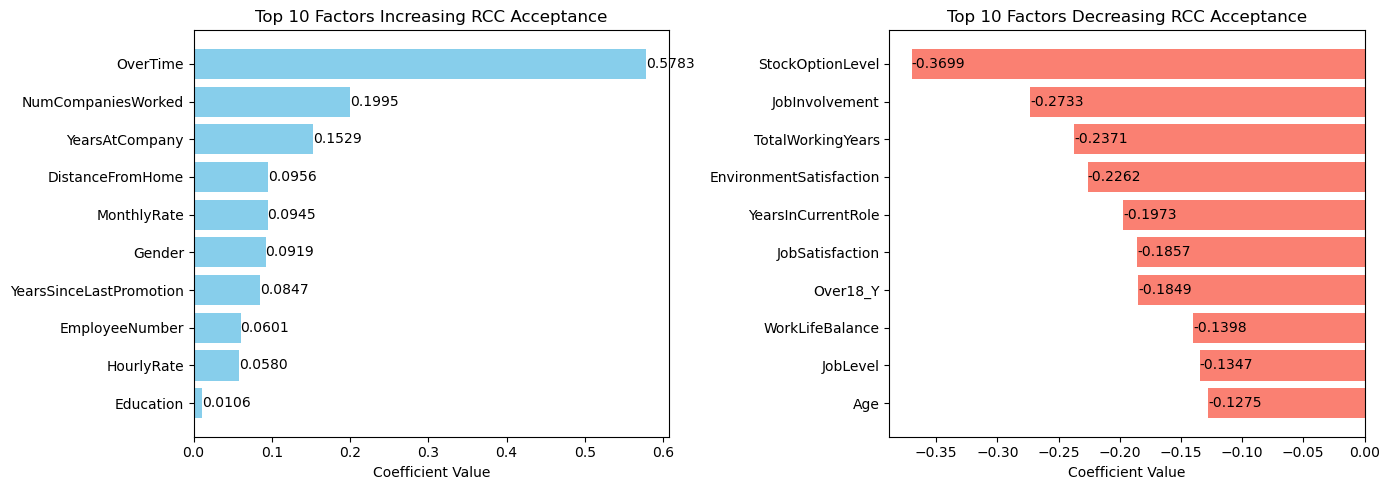

In [18]:
# Extract feature names after encoding
feature_names = preprocessor.get_feature_names_out()

# Clean up feature names by removing prefixes
clean_feature_names = [name.split('__')[-1] for name in feature_names]

# Extract coefficients and combine with feature names
coefficients = best_model.coef_[0]
importance_df = pd.DataFrame({'Feature': clean_feature_names, 'Coefficient': coefficients})

# Sort features by absolute coefficient value to find most important factors
importance_df['Abs_Coefficient'] = importance_df['Coefficient'].abs()
importance_df = importance_df.sort_values(by='Abs_Coefficient', ascending=False)

# Separate positive and negative factors
increasing_factors = importance_df[importance_df['Coefficient'] > 0].head(10)
decreasing_factors = importance_df[importance_df['Coefficient'] < 0].head(10)

# Display the top factors
print("Top 10 Factors Increasing RCC Acceptance:")
print(increasing_factors)

print("\nTop 10 Factors Decreasing RCC Acceptance:")
print(decreasing_factors)

plt.figure(figsize=(14, 5))

# Plot for increasing factors
plt.subplot(1, 2, 1)
bars = plt.barh(increasing_factors['Feature'], increasing_factors['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Top 10 Factors Increasing RCC Acceptance')
plt.gca().invert_yaxis()

# Display the coefficient value on each bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.4f}', va='center')

# Plot for decreasing factors
plt.subplot(1, 2, 2)
bars = plt.barh(decreasing_factors['Feature'], decreasing_factors['Coefficient'], color='salmon')
plt.xlabel('Coefficient Value')
plt.title('Top 10 Factors Decreasing RCC Acceptance')
plt.gca().invert_yaxis()

# Display the coefficient value on each bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.4f}', va='center')

plt.tight_layout()
plt.show()


### Key Factors Influencing RCC Acceptance

The chart above highlights the top 10 features that most strongly influence the likelihood of an employee accepting a Retention Compensation Contract (RCC), based on the coefficients from the logistic regression model.

#### Top Positive Predictors (Increased Likelihood of RCC Acceptance)
- **OverTime** stands out as the strongest positive predictor. Employees who frequently work overtime are significantly more likely to accept an RCC, possibly due to higher stress or workload.
- **NumCompaniesWorked** and **YearsAtCompany** suggest that employees with more job mobility or longer tenure may be more open to RCCs, reflecting either job fatigue or openness to change.
- Financial-related features such as **MonthlyRate** and **HourlyRate** also show moderate influence, indicating that salary-related factors may play a role in the decision-making process.
- **Gender** appears as a positive predictor, though further fairness analysis is necessary to ensure this effect is not inadvertently biased.

#### Top Negative Predictors (Decreased Likelihood of RCC Acceptance)
- **StockOptionLevel** has the largest negative impact. Employees with more stock options are less likely to accept RCC, likely due to stronger long-term financial incentives to stay.
- **JobInvolvement**, **JobSatisfaction**, and **EnvironmentSatisfaction** are also strong negative predictors, suggesting that more engaged and satisfied employees are less inclined to leave.
- **TotalWorkingYears** and **Age**, while meaningful, are sensitive variables with possible implications for fairness. These features need careful handling due to potential indirect bias, especially since `TotalWorkingYears` is moderately correlated with age (correlation ≈ 0.65).

#### Implications
These insights help target RCC offers more effectively by understanding the underlying factors driving acceptance. However, special care must be taken when interpreting variables that may be proxies for protected attributes to ensure the approach remains fair, unbiased, and legally compliant.


### Correlation Matrix: Identifying Potential Indirect Bias

The purpose of computing the correlation matrix is to examine relationships between numerical variables and identify any features that may be **indirectly correlated with potentially discriminatory attributes**, such as age. 

Even when explicitly sensitive variables (e.g., age, gender) are excluded from modeling, **indirect bias** can still be introduced through proxy variables that are highly correlated with them. For example, features like `TotalWorkingYears` may be moderately to strongly correlated with `Age`, and their inclusion in clustering or prediction models could unintentionally lead to **age-based discrimination**.

By visualizing the correlation matrix, we can:
- Detect such correlations between variables.
- Decide whether certain features should be excluded, transformed, or monitored.
- Ensure our clustering and prediction process aligns with fairness and compliance goals.

The heatmap below provides a quick and intuitive overview of the strength and direction of correlations among all numerical features in the dataset.

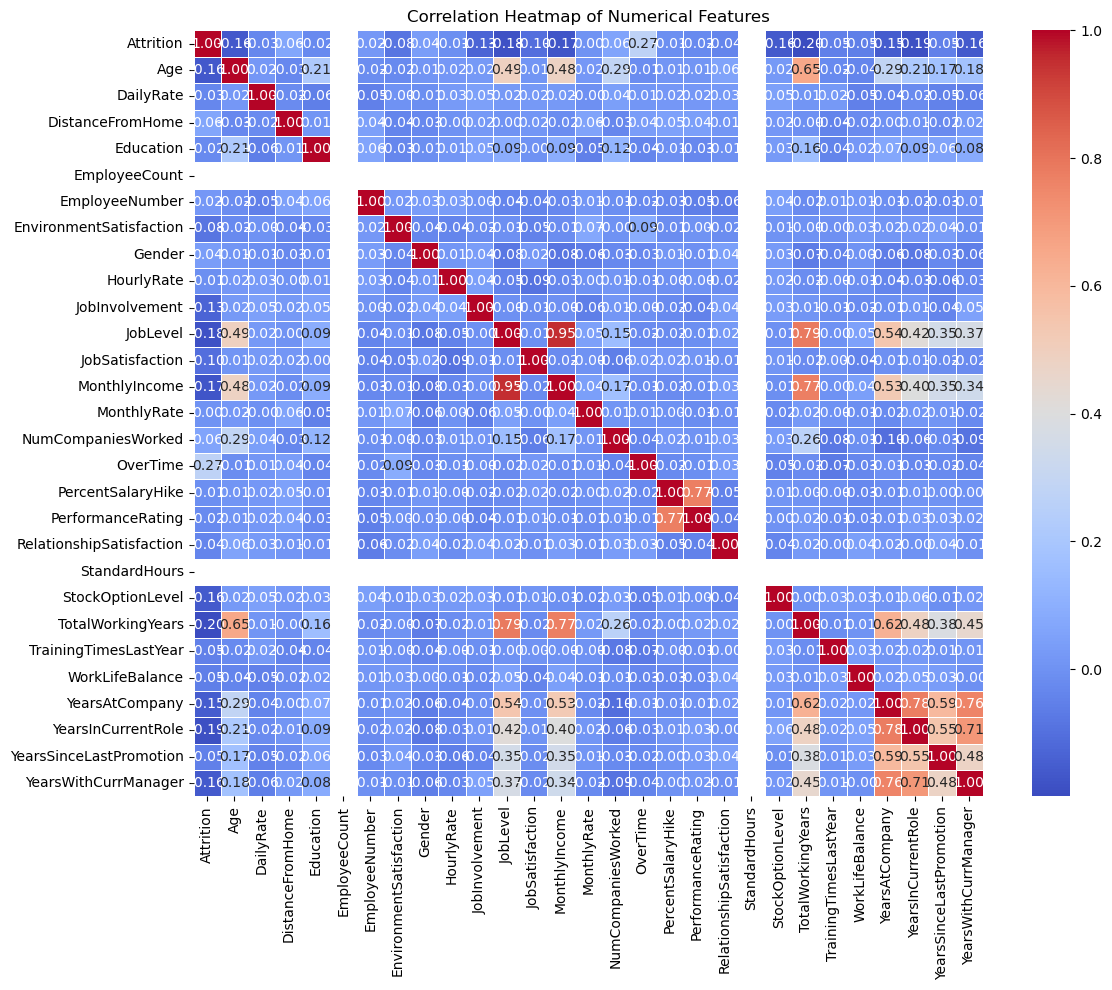

In [19]:
# Select only numerical columns for correlation
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()
plt.show()


## Task 2: RCC Acceptance Prediction for Lyon Office


In [20]:
# Load the Lyon dataset for prediction
df_lyon = pd.read_csv('employee_attrition_lyon.csv')

In [21]:
df_lyon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 441 entries, 0 to 440
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       386 non-null    float64
 1   BusinessTravel            436 non-null    object 
 2   DailyRate                 427 non-null    float64
 3   Department                441 non-null    object 
 4   DistanceFromHome          387 non-null    float64
 5   Education                 441 non-null    int64  
 6   EducationField            441 non-null    object 
 7   EmployeeCount             441 non-null    int64  
 8   EmployeeNumber            441 non-null    int64  
 9   EnvironmentSatisfaction   441 non-null    int64  
 10  Gender                    441 non-null    object 
 11  HourlyRate                441 non-null    int64  
 12  JobInvolvement            441 non-null    int64  
 13  JobLevel                  441 non-null    int64  
 14  JobRole   

In [22]:
# Count the number of employees in each department
department_count = df_lyon['Department'].value_counts()

# Display the count of employees per department
department_count

Department
Research & Development    285
Sales                     135
Human Resources            21
Name: count, dtype: int64

In [23]:
# Check for missing values
missing_values = df_lyon.isnull().sum()

# Display columns with missing values only
missing_values = missing_values[missing_values > 0]

# Print out the number of missing values
if not missing_values.empty:
    print("Columns with missing values:")
    print(missing_values)
else:
    print("No missing values found in the dataset.")

Columns with missing values:
Age                 55
BusinessTravel       5
DailyRate           14
DistanceFromHome    54
MaritalStatus        3
dtype: int64


In [24]:
# Identify numerical and categorical columns correctly
numerical_cols = df_lyon.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df_lyon.select_dtypes(include=['object']).columns.tolist()

# Handle missing values in the Lyon dataset
# Fill missing values in numerical columns with the median of each column
for col in numerical_cols:
    df_lyon[col].fillna(df_lyon[col].median(), inplace=True)

# Fill missing values in categorical columns with the most frequent (mode) value
for col in categorical_cols:
    df_lyon[col].fillna(df_lyon[col].mode()[0], inplace=True)

In [25]:
# Label Encoding for binary variables
le_lyon = LabelEncoder()
df_lyon['Gender'] = le_lyon.fit_transform(df_lyon['Gender'])
df_lyon['OverTime'] = le_lyon.fit_transform(df_lyon['OverTime'])

# One-Hot Encoding for multi-category variables
df_lyon = pd.get_dummies(df_lyon, columns=['BusinessTravel', 'Department', 'EducationField', 'JobRole', 'MaritalStatus'])

In [26]:
df_lyon_scaled = preprocessor.transform(df_lyon)

In [27]:
# Use the best model to make predictions on the Lyon dataset
predictions = best_model.predict_proba(df_lyon_scaled)[:, 1]

# Save the predictions to a CSV file with four decimal places
output = pd.DataFrame(predictions, columns=['RCC_Likelihood'])
output.to_csv('attrition_prediction.csv', index=False, float_format='%.4f')
print("Best model predictions saved to attrition_prediction.csv")


Best model predictions saved to attrition_prediction.csv


### Distribution of RCC Acceptance Probability in Lyon Office

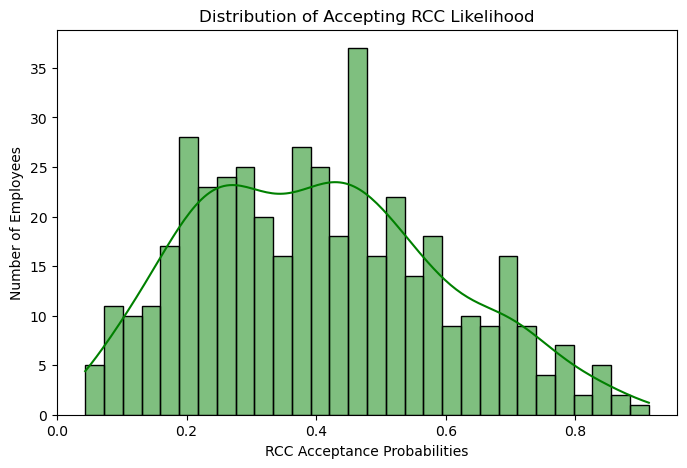

In [28]:
# Plot the distribution of RCC Likelihood
plt.figure(figsize=(8, 5))
sns.histplot(output['RCC_Likelihood'], bins=30, kde=True, color='green')
plt.title('Distribution of Accepting RCC Likelihood')
plt.xlabel('RCC Acceptance Probabilities')
plt.ylabel('Number of Employees')
plt.show()

In [29]:
df_lyon = pd.read_csv('employee_attrition_lyon.csv')

# Define the function to calculate severance cost
def calculate_severance(years_of_service, monthly_salary):
    if years_of_service < 10:
        # Use 1/4 for years less than 10
        return (1/4) * years_of_service * monthly_salary
    else:
        # Use 1/3 for entire years of service if 10 or more
        return (1/3) * years_of_service * monthly_salary

# Calculate the severance cost for each employee
df_lyon['SeveranceCost'] = df_lyon.apply(lambda x: calculate_severance(x['YearsAtCompany'], x['MonthlyIncome']), axis=1)

# Add the RCC_Likelihood column to the original dataset
df_lyon['RCC_Likelihood'] = predictions

# Save the updated dataframe to a new CSV file
df_lyon.to_csv('employee_attrition_lyon_CostRcc.csv', index=False, float_format='%.4f')

## Task 4. Grouping Employees

### Clustering Analysis for Lyon Office Dataset

This code performs clustering analysis on the **Lyon office dataset** to identify optimal clusters within each department. The primary goal is to group employees based on key attributes and find the best number of clusters using **K-Means**.

- A function `find_optimal_k()` is defined to determine the optimal number of clusters for each department.  
- The function uses two popular methods to assess cluster quality:  
  - **Elbow Method:** Evaluates cluster compactness using **inertia** (within-cluster sum of squares).  
  - **Silhouette Score:** Measures how similar an object is to its own cluster compared to others.  
- The function iterates through a range of cluster numbers (from 2 to 10) and calculates:  
  - **Inertia:** Lower values indicate more compact clusters.  
  - **Silhouette Score:** Higher values indicate well-separated clusters.  


Finding optimal K for Department: Human Resources


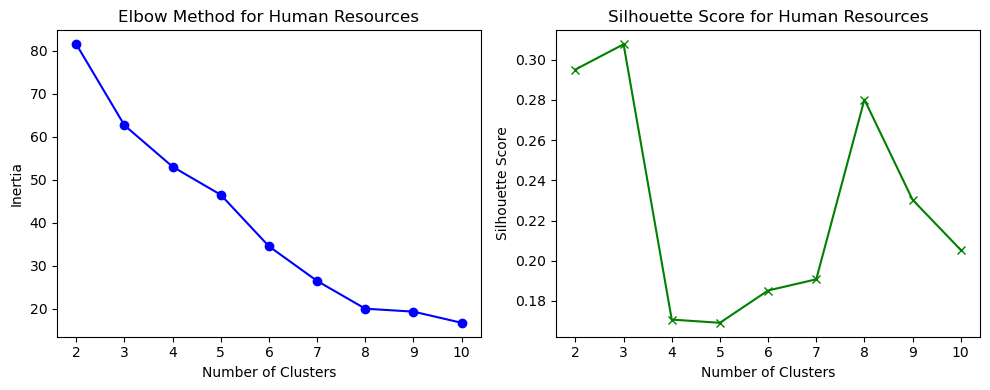

Finding optimal K for Department: Research & Development


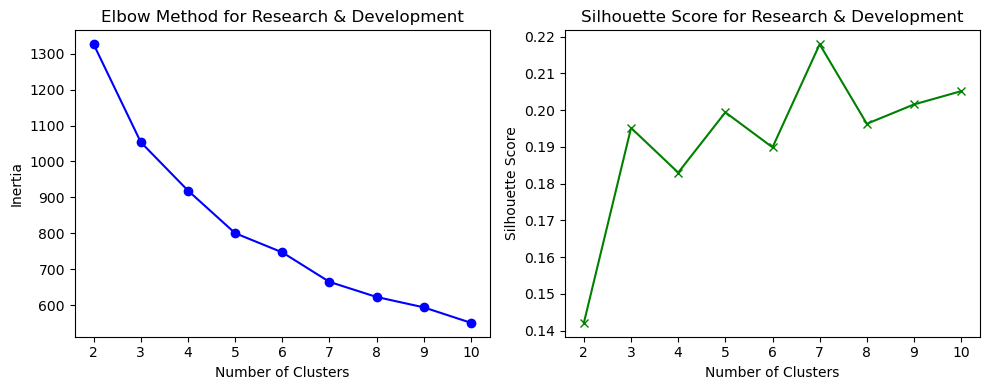

Finding optimal K for Department: Sales


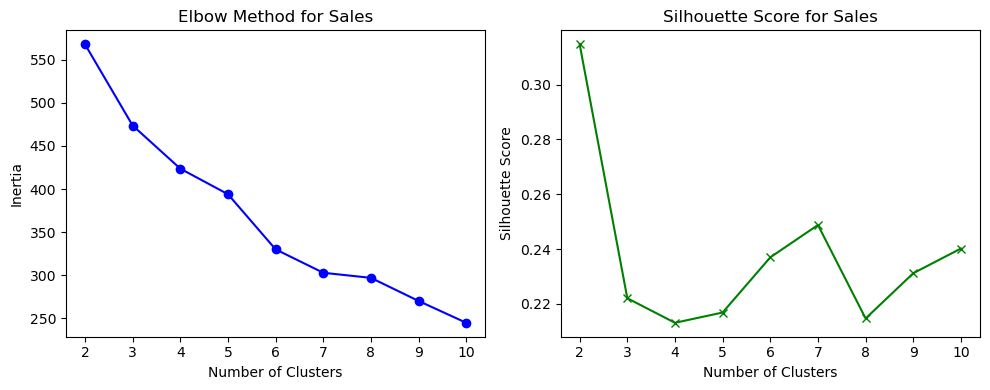

In [30]:
# Load the Lyon office dataset
df_lyon_RCC = pd.read_csv('employee_attrition_lyon_CostRcc.csv')

# Fill missing values similar to the training data
numerical_cols = ['NumCompaniesWorked', 'YearsAtCompany','StockOptionLevel', 'JobInvolvement', 'TotalWorkingYears']
categorical_cols = ['OverTime']

for col in numerical_cols:
    df_lyon_RCC[col].fillna(df_lyon_RCC[col].median(), inplace=True)
for col in categorical_cols:
    df_lyon_RCC[col].fillna(df_lyon_RCC[col].mode()[0], inplace=True)

# Remove 'Attrition' from numerical columns if present
if 'Attrition' in numerical_cols:
    numerical_cols.remove('Attrition')

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Function to find optimal K for each department
def find_optimal_k(group, dept_name):
    inertia = []
    silhouette_scores = []

    # Preprocess the data for this department
    X = preprocessor.fit_transform(group)

    # Check for optimal number of clusters from 2 to 10
    for k in range(2, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        clusters = kmeans.fit_predict(X)
        inertia.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, clusters))

    # Plot Elbow Method
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(2, 11), inertia, marker='o', linestyle='-', color='blue')
    plt.title(f"Elbow Method for {dept_name}")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")

    # Plot Silhouette Scores
    plt.subplot(1, 2, 2)
    plt.plot(range(2, 11), silhouette_scores, marker='x', linestyle='-', color='green')
    plt.title(f"Silhouette Score for {dept_name}")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")

    plt.tight_layout()
    plt.show()

# Apply the function for each department
for dept, group in df_lyon_RCC.groupby('Department'):
    print(f"Finding optimal K for Department: {dept}")
    find_optimal_k(group, dept)


- Human Resources: 3 clusters  
- Research & Development: 7 clusters  
- Sales: 7 clusters

### Clustering Employees by Department and Summarizing Cluster Characteristics

Below performs department-specific clustering on the Lyon office dataset to group employees into meaningful, objectively defined groups. It also computes key metrics for each cluster to support RCC decision-making.


In [31]:
# Dictionary to define number of clusters for each department
cluster_count = {
    'Human Resources': 3,
    'Research & Development': 7,
    'Sales': 7
}

# Create a list to store clustered data
clustered_data = []

# Group by department and apply clustering
for dept, group in df_lyon_RCC.groupby('Department'):
    # Preprocess the data for this department
    X = preprocessor.fit_transform(group)
    
    # Determine the number of clusters based on department
    n_clusters = cluster_count.get(dept) 
    
    # Apply KMeans clustering with the specified number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X)
    
    # Add the cluster labels to the original group
    group['Cluster'] = clusters
    group['Department'] = dept
    clustered_data.append(group)

# Concatenate clustered groups into a single DataFrame
clustered_df = pd.concat(clustered_data)

# Calculate each cluster's average severance cost, RCC likelihood, MonthlyIncome, and number of employees
cluster_summary = clustered_df.groupby(['Department', 'Cluster']).agg(
    Average_Severance_Cost=('SeveranceCost', 'mean'),
    Average_RCC_Likelihood=('RCC_Likelihood', 'mean'),
    Average_Monthly_Income=('MonthlyIncome', 'mean'),
    Employee_Count=('Cluster', 'size')
).reset_index()

# Save the cluster summary to a CSV file
cluster_summary.to_csv('department_cluster_summary.csv', index=False)
print("Cluster summary saved to department_cluster_summary.csv")

# Display the cluster summary
print(cluster_summary)


Cluster summary saved to department_cluster_summary.csv
                Department  Cluster  Average_Severance_Cost  \
0          Human Resources        0             6699.202379   
1          Human Resources        1            36086.333340   
2          Human Resources        2           127889.166650   
3   Research & Development        0            12913.531743   
4   Research & Development        1             5555.236110   
5   Research & Development        2             9439.776786   
6   Research & Development        3            11936.163263   
7   Research & Development        4           106482.683330   
8   Research & Development        5             9504.531836   
9   Research & Development        6            17276.627777   
10                   Sales        0            10451.269606   
11                   Sales        1            87048.933320   
12                   Sales        2            10482.419935   
13                   Sales        3            18139.820835   

### Non-Discriminatory Check

                Department  Cluster  Male_Count  Female_Count  Single_Count  \
0          Human Resources        0          10             4             6   
1          Human Resources        1           2             3             0   
2          Human Resources        2           2             0             1   
3   Research & Development        0          15             6             0   
4   Research & Development        1          25            23            29   
5   Research & Development        2          14            14             0   
6   Research & Development        3          31            18            19   
7   Research & Development        4          13             7             6   
8   Research & Development        5          56            33            33   
9   Research & Development        6          17            13             9   
10                   Sales        0          10             7             0   
11                   Sales        1           3     

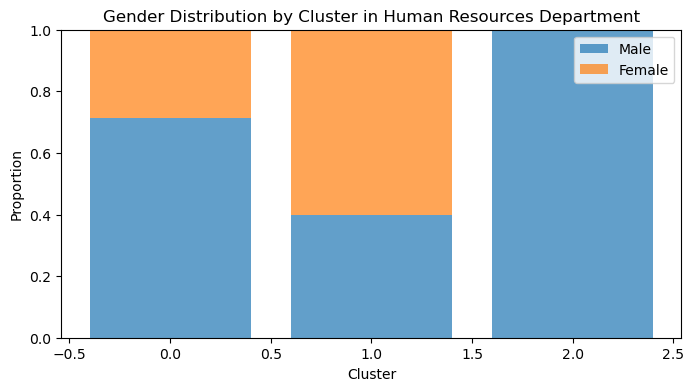

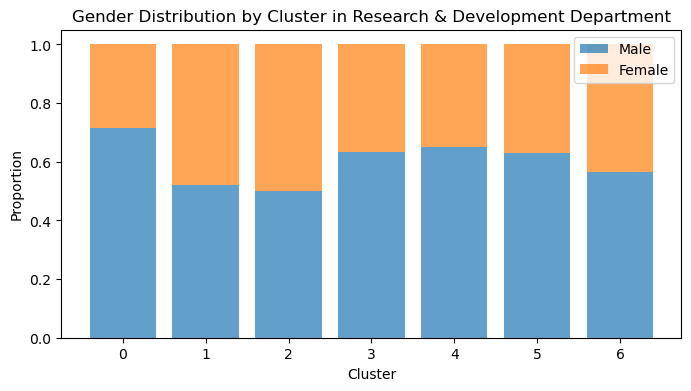

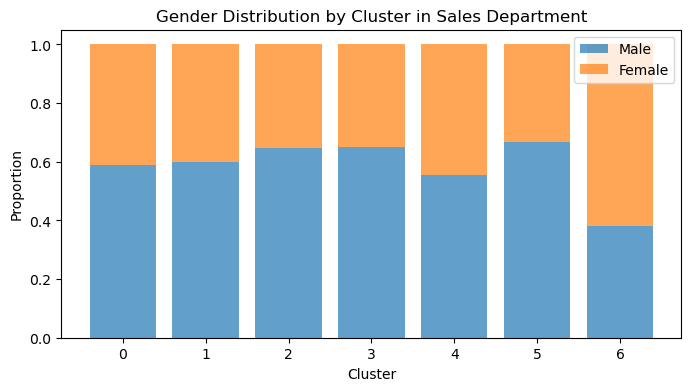

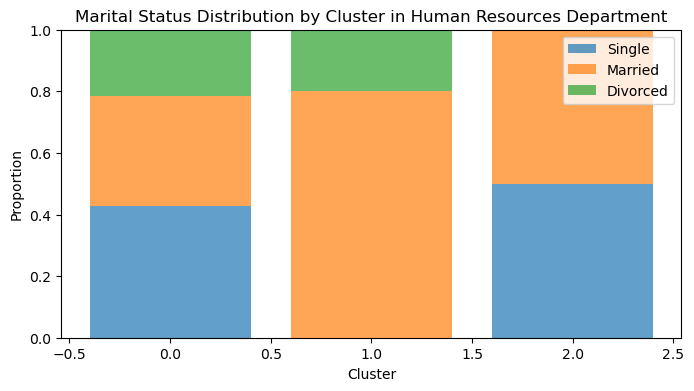

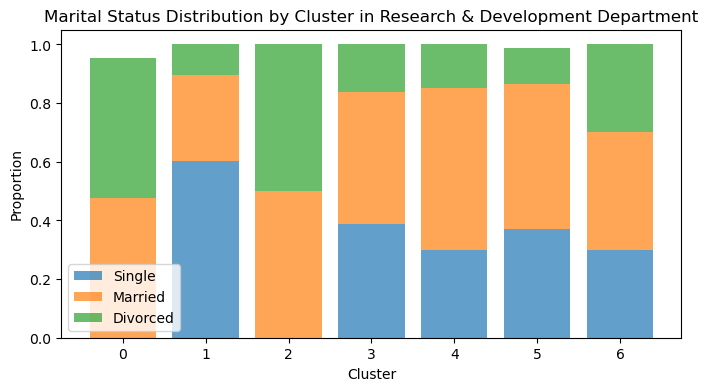

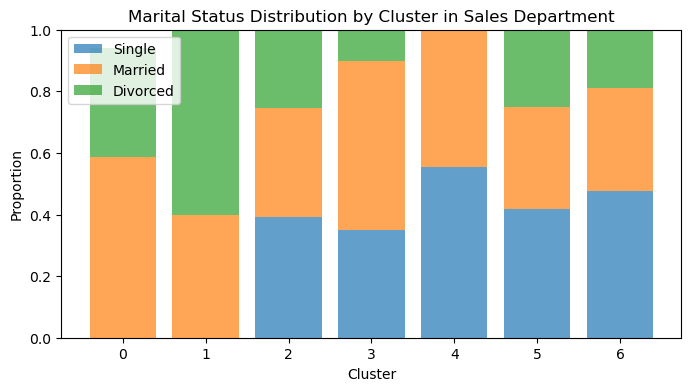

In [32]:
# Calculate distribution of Gender and MaritalStatus within each cluster and department
distribution_summary = clustered_df.groupby(['Department', 'Cluster']).agg(
    Male_Count=('Gender', lambda x: sum(x == 'Male')),
    Female_Count=('Gender', lambda x: sum(x == 'Female')),
    Single_Count=('MaritalStatus', lambda x: sum(x == 'Single')),
    Married_Count=('MaritalStatus', lambda x: sum(x == 'Married')),
    Divorced_Count=('MaritalStatus', lambda x: sum(x == 'Divorced')),
    Total_Count=('Gender', 'size')
).reset_index()

# Add proportion columns
distribution_summary['Male_Proportion'] = distribution_summary['Male_Count'] / distribution_summary['Total_Count']
distribution_summary['Female_Proportion'] = distribution_summary['Female_Count'] / distribution_summary['Total_Count']
distribution_summary['Single_Proportion'] = distribution_summary['Single_Count'] / distribution_summary['Total_Count']
distribution_summary['Married_Proportion'] = distribution_summary['Married_Count'] / distribution_summary['Total_Count']
distribution_summary['Divorced_Proportion'] = distribution_summary['Divorced_Count'] / distribution_summary['Total_Count']

# Display the distribution summary
print(distribution_summary)

# Visualize the distribution of Gender proportions in each cluster
for dept in clustered_df['Department'].unique():
    dept_data = distribution_summary[distribution_summary['Department'] == dept]

    plt.figure(figsize=(8, 4))
    plt.bar(dept_data['Cluster'], dept_data['Male_Proportion'], label='Male', alpha=0.7)
    plt.bar(dept_data['Cluster'], dept_data['Female_Proportion'], bottom=dept_data['Male_Proportion'], label='Female', alpha=0.7)
    plt.xlabel('Cluster')
    plt.ylabel('Proportion')
    plt.title(f'Gender Distribution by Cluster in {dept} Department')
    plt.legend()
    plt.show()

# Visualize the distribution of MaritalStatus proportions in each cluster
for dept in clustered_df['Department'].unique():
    dept_data = distribution_summary[distribution_summary['Department'] == dept]

    plt.figure(figsize=(8, 4))
    plt.bar(dept_data['Cluster'], dept_data['Single_Proportion'], label='Single', alpha=0.7)
    plt.bar(dept_data['Cluster'], dept_data['Married_Proportion'], bottom=dept_data['Single_Proportion'], label='Married', alpha=0.7)
    plt.bar(dept_data['Cluster'], dept_data['Divorced_Proportion'], 
            bottom=dept_data['Single_Proportion'] + dept_data['Married_Proportion'], label='Divorced', alpha=0.7)
    plt.xlabel('Cluster')
    plt.ylabel('Proportion')
    plt.title(f'Marital Status Distribution by Cluster in {dept} Department')
    plt.legend()
    plt.show()
